<a href="https://colab.research.google.com/github/HaakonVikesaa/2022-ML-project/blob/main/Machine_learning_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [43]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score 
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import cross_val_score
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV
from sklearn import svm
import cv2
import time
from PIL import Image
from sklearn.linear_model import LogisticRegression

In [44]:
#%%
df = pd.read_csv('Landslides.csv')

#X_train,X_test,y_train,y_test = train_test_split(X, y, test_size=0.2, random_state=42)
#Feature importance, comparrison of random forrest and SVM 

listofindex = ['dist_roads','DEM','TWI','plan_curvature','profil_curvature','Slope',
               'carbonates','glacial deposits','detrital rocks','alluvial deposits','marly-limestone','slope deposits','metamorphic rocks','evaporitic rocks','artificial materials',
               'forest','herbaceous vegetation','shrub vegetation','impermeable man-made','no vegetation','permeable man-made','glacier  water body']



enc = OneHotEncoder(sparse=False) #Activates the OneHotEncoder


geology_onehot = enc.fit_transform(df[['Geology']]) #Fits and transforms the dataframe coloum into multiple columns of 0 and 1
Landcover_onehot = enc.fit_transform(df[['LandCover']]) #Fits and transforms the dataframe coloum into multiple columns of 0 and 1


geology_tranform = pd.DataFrame(geology_onehot) #transfor the array into a DataFrame
Landcover_tranform = pd.DataFrame(Landcover_onehot) #transfor the array into a DataFrame


geology_tranform= geology_tranform.add_prefix('g_') #Changes the prefix of the coloum into the specified one
Landcover_tranform= Landcover_tranform.add_prefix('lc_') #Changes the prefix of the coloum into the specified one


 #Removes the geology and Landcover coloums from the inputs dataframe since they are added as multiple colus of 0 and 1
inputs_df = pd.DataFrame(df.drop(['Geology','LandCover','LS'],axis = 1)) #Defines the inputs_df as df and  a DataFrame and Removes the geology and Landcover coloums from the inputs dataframe since they are added as multiple colus of 0 and 1

inputs_df = inputs_df.join(geology_tranform) #Adds the geology 0 and 1 colouns to the inputs_df
inputs_df = inputs_df.join(Landcover_tranform) #Adds the geology 0 and 1 colouns to the inputs_df

In [45]:
#%% Splitting
landslideindex = [] #Creates a enpty list that is going to be used for storing the indexes for the rows that contain a landslide
#landslideindex = pd.DataFrame(np.array(landslideindex))
for index,value in enumerate(df['LS']): #A for loop that checks very row and adds the index of the ros that contain a landslide into a list
    if value == 1:
        landslideindex.append(index)
        
outputs = np.zeros_like(df['LS']) #Creates a list of zeroes as long as LS coloum of df
for i in landslideindex: #A for loop that changes all the zeroes at the indexes that has a landslide into a 1
    outputs[i] = 1 #Makes the same a df['LS']

all_indices = np.arange(0,len(outputs),1) # Creates a array counting from 0 to len(outputs) with step 1
if not type(inputs_df) == 'numpy.ndarray':
  inputs_df = inputs_df.to_numpy() #Changes the inputs_df to a numpy array

indx_train, indx_test = train_test_split(all_indices,test_size=0.15,random_state=1)
indx_train, indx_val = train_test_split(indx_train,test_size=0.15,random_state=1)

#Splitting the data
X_train,y_train = inputs_df[indx_train],outputs[indx_train]
X_val,y_val = inputs_df[indx_val],outputs[indx_val]
X_test,y_test = inputs_df[indx_test],outputs[indx_test]

X_train = pd.DataFrame(X_train)
X_val = pd.DataFrame(X_val)
X_test = pd.DataFrame(X_test)

In [46]:
#Random forrest classifier
rfc = RandomForestClassifier()

rfc.fit(X_train,y_train)

rfc_predict = rfc.predict(X_test)

rfc_accuracy = accuracy_score(y_test, rfc_predict)

print('The accuracy of basic RandomForestClassifier:',"%.3f" %rfc_accuracy)

The accuracy of basic RandomForestClassifier: 0.846


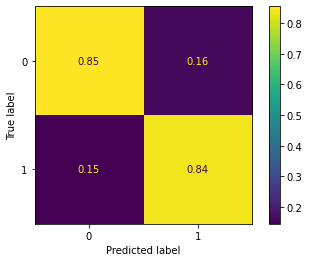

In [47]:
cm = confusion_matrix(y_test, rfc_predict, normalize='pred') # Get a confusion matrix 'cm', use 'pred' for the normalize option
disp = ConfusionMatrixDisplay(confusion_matrix = cm) # Use ConfusionMatrixDisplay to visualize 'cm'
disp.plot()

    

importances = rfc.feature_importances_
std = np.std([tree.feature_importances_ for tree in rfc.estimators_], axis=0)

x_axis = np.arange(1,len(importances)+1)
forest_importances = pd.Series(importances,index = listofindex)



In [48]:
print(forest_importances)
print(type(forest_importances))

dist_roads               0.162702
DEM                      0.116955
TWI                      0.117155
plan_curvature           0.103541
profil_curvature         0.124816
Slope                    0.251346
carbonates               0.011443
glacial deposits         0.021192
detrital rocks           0.005779
alluvial deposits        0.005512
marly-limestone          0.001499
slope deposits           0.005791
metamorphic rocks        0.016059
evaporitic rocks         0.000576
artificial materials     0.002257
forest                   0.010411
herbaceous vegetation    0.005627
shrub vegetation         0.016612
impermeable man-made     0.004320
no vegetation            0.011858
permeable man-made       0.003753
glacier  water body      0.000795
dtype: float64
<class 'pandas.core.series.Series'>


<ipython-input-49-f8c2b9da9e89>:5: FutureWarning: In a future version of pandas all arguments of Series.sort_values will be keyword-only
  forest_importances.sort_values('index', ascending=False).plot.barh(yerr=std, ax=ax)


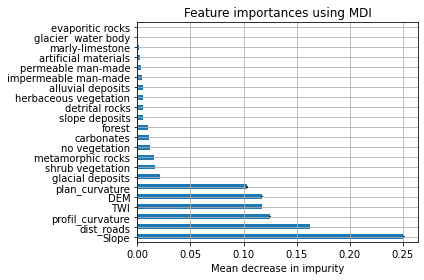

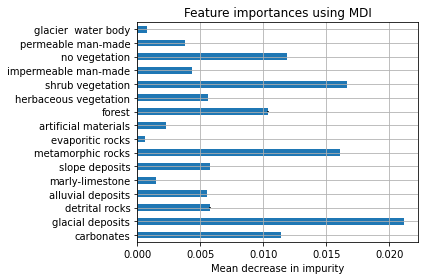

In [49]:
feature_importances_rf = pd.DataFrame({'Feature'     : listofindex,
        'Index Title'  : importances})
 
fig, ax = plt.subplots()
forest_importances.sort_values('index', ascending=False).plot.barh(yerr=std, ax=ax)
#bars = ax.bar(feature_importances_rf, importances, align='center')
#ax.set_xticks(importances, labels=listofindex)
ax.grid()
ax.plot()
ax.set_title("Feature importances using MDI")
ax.set_xlabel("Mean decrease in impurity")
fig.tight_layout()

# Just geology and landcover
fig, ax = plt.subplots()
forest_importances[6:].plot.barh(yerr=std[6:], ax=ax)
plt.xticks(np.arange(0, max(forest_importances[6:])+0.1, 0.005))
ax.plot()
ax.grid()
ax.set_title("Feature importances using MDI")
ax.set_xlabel("Mean decrease in impurity")
fig.tight_layout()

In [50]:
rfcopt = RandomForestClassifier()
n_estimators = []
for i in np.arange(100,501,50):
  n_estimators.append(int(i))
param_grid = {'n_estimators': n_estimators,
              'max_features': [2,3,4,5]}
clf = HalvingGridSearchCV(rfcopt,param_grid,
                              max_resources=2000,
                              random_state=1)
clf.fit(X_train, y_train)
best_grid = clf.best_params_
print('best parameters:',best_grid)


best parameters: {'max_features': 3, 'n_estimators': 150}


In [51]:
rfcopt=RandomForestClassifier(max_features= 5, n_estimators= 450)
rfcopt.fit(X_train,y_train)
rfcopt_predict = rfcopt.predict(X_test)
rfcopt_accuracy = accuracy_score(y_test, rfcopt_predict)

print('The accuracy of improved RandomForestClassifier:',"%.3f" %rfcopt_accuracy)
print('The accuracy of basic RandomForestClassifier:',"%.3f" %rfc_accuracy)

The accuracy of improved RandomForestClassifier: 0.839
The accuracy of basic RandomForestClassifier: 0.846


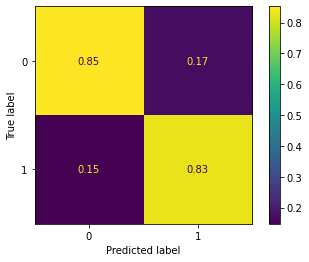

In [42]:
cm = confusion_matrix(y_test, rfcopt_predict, normalize='pred') # Get a confusion matrix 'cm', use 'pred' for the normalize option
disp = ConfusionMatrixDisplay(confusion_matrix = cm) # Use ConfusionMatrixDisplay to visualize 'cm'
disp.plot()

The The accuracy of basic Logistic regression: 0.803


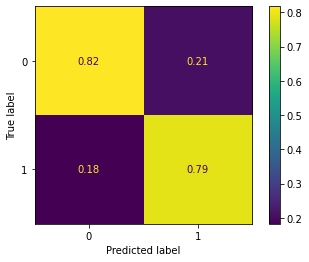

In [52]:
logreg = LogisticRegression(max_iter=2000,random_state=1)
logreg.fit(X_train,y_train)
logreg_predict = logreg.predict(X_test)
logleg_accuracy = accuracy_score(y_test, logreg_predict)

print('The The accuracy of basic Logistic regression:', "%.3f" %logleg_accuracy)

cm = confusion_matrix(y_test, logreg_predict, normalize='pred') # Get a confusion matrix 'cm', use 'pred' for the normalize option
disp = ConfusionMatrixDisplay(confusion_matrix = cm) # Use ConfusionMatrixDisplay to visualize 'cm'
disp.plot()

In [53]:
param_grid = [
  {'solver': ['newton-cg', 'lbfgs', 'liblinear'], 
   'penalty': ['l2'],
  'C': [100, 10, 1.0, 0.1, 0.01],
  'max_iter':[2000,5000,10000,20000],}]
clf = HalvingGridSearchCV(logreg, param_grid,
                          max_resources=2000,
                          random_state=1)
clf.fit(X_train, y_train)
best_grid = clf.best_params_
print('best parameters:',best_grid)
#best parameters: {'C': 0.5, 'max_iter': 10000, 'penalty': 'none', 'solver': 'sag'}

/usr/local/lib/python3.8/dist-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.8/dist-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)


best parameters: {'C': 1.0, 'max_iter': 10000, 'penalty': 'l2', 'solver': 'liblinear'}


In [54]:
#%% Optimized logistic regression

logregopt = LogisticRegression(max_iter=10000,random_state=1,C=1,solver = 'liblinear',penalty= 'l2')
logregopt.fit(X_train,y_train)
logregopt_predict = logregopt.predict(X_test)
loglegopt_accuracy = accuracy_score(y_test, logregopt_predict)

print('The The accuracy of basic Logistic regression:', "%.3f" %logleg_accuracy)
print('The The accuracy of improved Logistic regression:', "%.3f" %loglegopt_accuracy)



The The accuracy of basic Logistic regression: 0.803
The The accuracy of improved Logistic regression: 0.805


In [55]:
DEM = cv2.imread('DEM.tif',-1)
distance_road = cv2.imread('dist_roads.tif',-1)
geology = cv2.imread('Geology.tif',-1)
landcover = cv2.imread('LandCover.tif',-1)
plan_curvature = cv2.imread('plan_curvature.tif',-1)
profile_curvature = cv2.imread('profil_curvature.tif',-1)
slope = cv2.imread('Slope.tif',-1)
TWI = cv2.imread('TWI.tif',-1)

In [56]:

prediction = np.zeros(DEM.shape)
counter = 0
for i in range(TWI.shape[0]):
    if i%10 ==1:
        counter +=1
        print(counter)
    for j in range(TWI.shape[1]):
        if not geology[i][j] == geology[0][0] and not DEM[i][j] == DEM[0][0]:
            if not geology[i][j] ==37:
                if not landcover[i][j] == 255:
                    reusedataframe = pd.DataFrame([])
                    pixel = {'dist_roads': [distance_road[i][j]], 
                                'DEM': [DEM[i][j]], 
                                'TWI': [TWI[i][j]],
                                'plan_curvature': [plan_curvature[i][j]], 
                                'profil_curvature':[profile_curvature[i][j]], 
                                'Slope': [slope[i][j]], 
                                #'Geology': [geology[i][j]],
                                #'LandCover': [landcover[i][j]], 
                                }
                    
                    reusedataframe = pd.DataFrame(pixel)
                    reusedataframe = reusedataframe.to_numpy()
                    

                    geology_dic = {'1': [2,1,24,9,7,11,31,36,10,geology[i][j]]}    
                    geology_df = pd.DataFrame(geology_dic)
                    
                    landcover_dic = {'1': [41,21,31,11,51,15,62,landcover[i][j]]} 
                    landcover_df = pd.DataFrame(landcover_dic)
            
            
                  
                    geology_onehot = enc.fit_transform(geology_df)
                    Landcover_onehot = enc.fit_transform(landcover_df)
                    reusedataframe = np.concatenate((reusedataframe, geology_onehot[-1], Landcover_onehot[-1]),axis=None).reshape(1,-1)
                    ##reusedataframe = reusedataframe.join(pd.DataFrame(geology_tranform.iloc[-1])) #Adds the geology 0 and 1 colouns to the inputs_df
                    ##reusedataframe = reusedataframe.join(pd.DataFrame(Landcover_tranform.iloc[-1]))
            
                    #reusedataframe.drop(['Geology','LandCover'], axis=1)
                    prediction[i][j] = rfc.predict(reusedataframe)

AttributeError: ignored

In [ ]:
fig = plt.imshow(prediction)
fig.set_cmap('hot')
fig.axes.get_xaxis().set_visible(False)
fig.axes.get_yaxis().set_visible(False)